**Mount Google Drive**

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Setup**

In [2]:
!apt-get update -qq > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.4.2/spark-3.4.2-bin-hadoop3.tgz
!tar xf spark-3.4.2-bin-hadoop3.tgz
!pip install -q findspark

In [3]:
import os
import pandas as pd

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.2-bin-hadoop3"

import findspark

findspark.init()

from pyspark.sql import SparkSession
import random

spark = SparkSession.builder.appName("YourTest") \
    .master("local[2]") \
    .config('spark.ui.port', random.randrange(4000, 5000)) \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.3-spark3.4-s_2.12") \
    .getOrCreate()

from graphframes import GraphFrame
from graphframes.lib import Pregel
import pyspark.sql.functions as f

spark.sparkContext.setCheckpointDir("./checkpoint/")


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Load the data
df = spark.read.csv("/content/drive/MyDrive/twitch_gamers/large_twitch_edges.csv", header=True)

# Get all vertices
all_vertices = df.select("numeric_id_1").union(df.select("numeric_id_2")).distinct()

# Get dead ends
missing_vertices = all_vertices.subtract(df.select("numeric_id_1").distinct())

# Add loop
missing_edges_df = missing_vertices.withColumnRenamed("numeric_id_1", "src").withColumn("dst", col("src"))

# Concatenate the dataframes
df = df.union(missing_edges_df)

df.write.option("header", "true").mode('overwrite').csv('/content/drive/MyDrive/twitch_gamers/loop.csv')


In [ ]:
from pyspark.sql import functions as f
from pyspark.sql.functions import collect_set, size
from graphframes import *
from pyspark.sql.functions import sum as _sum

# Load the features DataFrame
features = spark.read.format("csv").option("header", "true").load("/content/drive/MyDrive/twitch_gamers/large_twitch_features.csv")

# Load the edges DataFrame
twitch_gamers = spark.read.format("csv").option("header", "true").load(
    "/content/drive/MyDrive/twitch_gamers/large_twitch_edges.csv").withColumnRenamed("numeric_id_1",
                                                      "src").withColumnRenamed("numeric_id_2", "dst")

vertices = twitch_gamers.select("src").union(twitch_gamers.select("dst")).distinct().withColumnRenamed("src", "id")

# Join the features DataFrame with the vertices DataFrame to add the language attribute
vertices = vertices.join(features.select("numeric_id", "language"), vertices.id == features.numeric_id, "left_outer")

# Create a new edges DataFrame where each edge represents a connection between users who speak the same language
edges = twitch_gamers.alias("e").join(vertices.alias("v1"), f.col("e.src") == f.col("v1.id")).join(vertices.alias("v2"),
          f.col("e.dst") == f.col("v2.id")).filter(f.col("v1.language") == f.col("v2.language")).select(f.col("e.src").alias("src"),
                                                                                                      f.col("e.dst").alias("dst"))

# Create the new graph
graph_language = GraphFrame(vertices, edges)

# Find connected components
connected_components = graph_language.connectedComponents()

# Group by language and component
communities_by_language = connected_components.groupBy("language", "component")

# Count the number of users in each community
communities_by_language = communities_by_language.agg(f.count("id").alias("num_users"))

# Calculate the total number of communities and users for each language
communities_by_language = communities_by_language.groupBy("language").agg(f.count("component").alias("num_communities"), _sum("num_users").alias("total_users"))

# Show the communities grouped by language
communities_by_language.show()

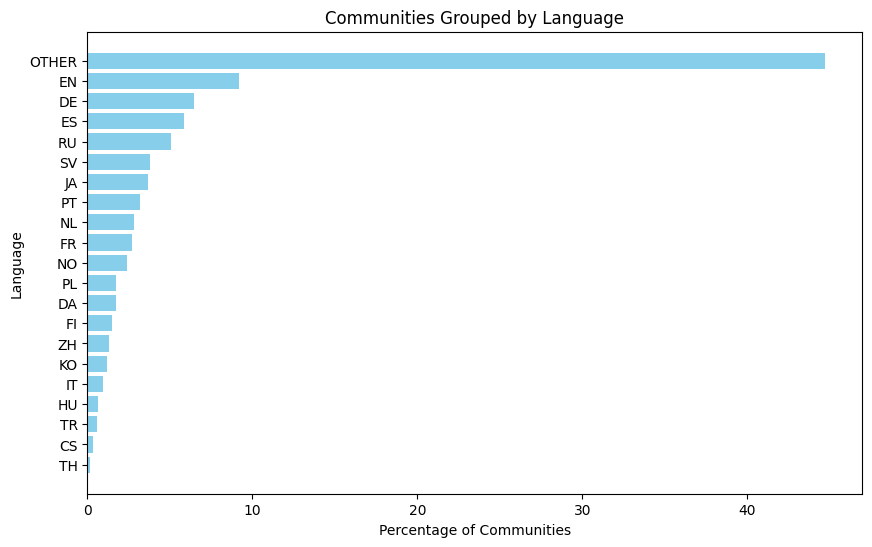

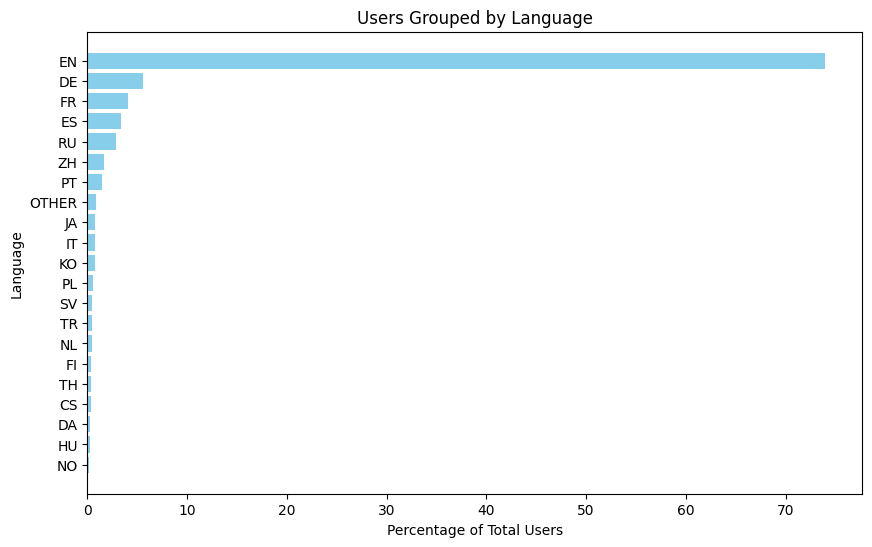

In [ ]:
# Show the communities grouped by language, sorted by total_users in descending order
#communities_by_language.orderBy(f.desc("total_users")).show()
import matplotlib.pyplot as plt

# Convert the DataFrame to Pandas
communities_by_language_pd = communities_by_language.toPandas()

# Calculate the percentage of total users for each language
communities_by_language_pd['percentage'] = (communities_by_language_pd['num_communities'] / communities_by_language_pd['num_communities'].sum()) * 100

# Sort the data by percentage in descending order
communities_by_language_pd = communities_by_language_pd.sort_values('percentage', ascending=False)

# Plot the data
plt.figure(figsize=(10, 6))
plt.barh(communities_by_language_pd['language'], communities_by_language_pd['percentage'], color='skyblue')
plt.xlabel('Percentage of Communities')
plt.ylabel('Language')
plt.title('Communities Grouped by Language')
plt.gca().invert_yaxis()  # invert the y-axis to show the language with the highest percentage at the top
plt.show()


# Calculate the percentage of total users for each language
communities_by_language_pd['percentage'] = (communities_by_language_pd['total_users'] / communities_by_language_pd['total_users'].sum()) * 100

# Sort the data by percentage in descending order
communities_by_language_pd = communities_by_language_pd.sort_values('percentage', ascending=False)

# Plot the data
plt.figure(figsize=(10, 6))
plt.barh(communities_by_language_pd['language'], communities_by_language_pd['percentage'], color='skyblue')
plt.xlabel('Percentage of Total Users')
plt.ylabel('Language')
plt.title('Users Grouped by Language')
plt.gca().invert_yaxis()  # invert the y-axis to show the language with the highest percentage at the top
plt.show()


In [7]:
# Read the excel file / rename columns
twitch_gamers = spark.read.format("csv").option("header", "false").load(
    "/content/drive/MyDrive/twitch_gamers/loop.csv").withColumnRenamed("_c0",
                                  "src").withColumnRenamed(
    "_c1", "dst")


vertices = twitch_gamers.select("src").union(twitch_gamers.select("dst")).distinct().withColumnRenamed("src", "id")

edges = twitch_gamers.select("src", "dst")
graph = GraphFrame(vertices, edges)

# Show graph
graph.vertices.show()
graph.edges.show()


+------+
|    id|
+------+
|113417|
|128181|
| 13772|
| 42688|
|106585|
|140876|
| 46683|
| 17427|
|102521|
|  2162|
| 29454|
| 82197|
|131033|
|154118|
|147244|
| 90391|
|149687|
| 76686|
| 57569|
| 80258|
+------+
only showing top 20 rows

+------------+------------+
|         src|         dst|
+------------+------------+
|numeric_id_1|numeric_id_2|
|       98343|      141493|
|       98343|       58736|
|       98343|      140703|
|       98343|      151401|
|       98343|      157118|
|       98343|      125430|
|       98343|        3635|
|       98343|         495|
|       98343|      116648|
|       98343|        1679|
|       98343|      123861|
|       98343|       89631|
|       98343|      113417|
|       98343|      145281|
|       98343|       10408|
|       98343|        3181|
|       98343|       40675|
|       98343|       95914|
|       98343|      155127|
+------------+------------+
only showing top 20 rows



**In degree function**

In [4]:
# Implement in_degree function
def in_Degrees(graph):
    in_degrees = graph.edges.groupBy("dst").count().select(f.col("dst").alias("id"),
                                                            f.col("count").alias("in_degree"))

    # for 0 outdegree
    return graph.vertices.join(in_degrees, "id", "left_outer").select("id", "in_degree").na.fill(0)

# Implement out_degree function
def out_Degrees(graph):
    out_degrees = graph.edges.groupBy("src").count().select(f.col("src").alias("id"),
                                                            f.col("count").alias("out_degree"))

    # for 0 outdegree
    return graph.vertices.join(out_degrees, "id", "left_outer").select("id", "out_degree").na.fill(0)

 # find the most connected user
def most_connected_user(graph):

    out_degrees = out_Degrees(graph)
    most_connected = out_degrees.orderBy(f.col("out_degree").desc()).first()
    return most_connected

**PageRank**

In [5]:
# Implement Page Rank

def page_rank(graph, resetProbability=0.15, sourceId=None, maxIter=None, tol=None):
    """
    Runs the PageRank algorithm on the graph.
    Note: Exactly one of fixed_num_iter or tolerance must be set.

    See Scala documentation for more details.

    :param resetProbability: Probability of resetting to a random vertex.
    :param sourceId: (optional) the source vertex for a personalized PageRank.
    :param maxIter: If set, the algorithm is run for a fixed number
            of iterations. This may not be set if the `tol` parameter is set.
    :param tol: If set, the algorithm is run until the given tolerance.
            This may not be set if the `numIter` parameter is set.
    :return:  GraphFrame with new vertices column "pagerank" and new edges column "weight"
    """

    num_vertex = graph.vertices.count()

    # Calculate in-degree
    in_degrees = in_Degrees(graph)
    in_degrees = in_degrees.withColumnRenamed("id", "in_degree_id")
    # Join the DataFrames and add the in_degree column
    vertices = graph.vertices.join(in_degrees, graph.vertices["id"] == in_degrees["in_degree_id"], "left").drop(
        "in_degree_id")
    # Update the graph with in_degree
    graph = GraphFrame(vertices, edges)

    # Iteration version
    if sourceId is not None:
        if maxIter is not None:
            ranks = graph.pregel \
                .setMaxIter(maxIter) \
                .withVertexColumn("pagerank", f.when(graph.vertices.id == sourceId, f.lit(1.0)) \
                                  .otherwise(f.lit(0.0)), \
                                  f.coalesce(Pregel.msg(), f.lit(0.0)) * f.lit(1.0 - resetProbability) + f.when(
                                      graph.vertices.id == sourceId, f.lit(resetProbability)).otherwise(f.lit(0.0))) \
                .sendMsgToDst(Pregel.src("pagerank") / Pregel.src("in_degree")) \
                .aggMsgs(f.sum(Pregel.msg())) \
                .run()
            return GraphFrame(ranks, graph.edges)
    elif maxIter is not None:
        ranks = graph.pregel \
            .setMaxIter(maxIter) \
            .withVertexColumn("pagerank", f.lit(1.0 / num_vertex), \
                              f.coalesce(Pregel.msg(), f.lit(0.0)) * f.lit(1.0 - resetProbability) + f.lit(
                                  resetProbability / num_vertex)) \
            .sendMsgToDst(Pregel.src("pagerank") / Pregel.src("in_degree")) \
            .aggMsgs(f.sum(Pregel.msg())) \
            .run()
        return GraphFrame(ranks, graph.edges)

    # init rank
    # running first iteration for the convergence version
    if sourceId is not None:
        ranks = graph.pregel \
            .setMaxIter(1) \
            .withVertexColumn("pagerank", f.when(graph.vertices.id == sourceId, f.lit(1.0)) \
                              .otherwise(f.lit(0.0)), \
                              f.coalesce(Pregel.msg(), f.lit(0.0)) * f.lit(1.0 - resetProbability) + f.when(
                                  graph.vertices.id == sourceId, f.lit(resetProbability)).otherwise(f.lit(0.0))) \
            .sendMsgToDst(Pregel.src("pagerank") / Pregel.src("in_degree")) \
            .aggMsgs(f.sum(Pregel.msg())) \
            .run()
    else:
        ranks = graph.pregel \
            .setMaxIter(1) \
            .withVertexColumn("pagerank", f.lit(1.0 / num_vertex), \
                              f.coalesce(Pregel.msg(), f.lit(0.0)) * f.lit(1.0 - resetProbability) + f.lit(
                                  resetProbability / num_vertex)) \
            .sendMsgToDst(Pregel.src("pagerank") / Pregel.src("in_degree")) \
            .aggMsgs(f.sum(Pregel.msg())) \
            .run()
    # goes into convergence  check
    ranks = ranks.withColumnRenamed("pagerank", "previous_pagerank")
    graph = GraphFrame(ranks, graph.edges)
    iterationNum = 0
    # tol
    while 1:
        # new pagerank
        iterationNum += 1
        if sourceId is not None:
            new = graph.pregel \
                .setMaxIter(1) \
                .withVertexColumn("pagerank", graph.vertices["previous_pagerank"], \
                                  f.coalesce(Pregel.msg(), f.lit(0.0)) * f.lit(1.0 - resetProbability) + f.when(
                                      graph.vertices.id == sourceId, f.lit(resetProbability)).otherwise(f.lit(0.0))) \
                .sendMsgToDst(Pregel.src("pagerank") / Pregel.src("in_degree")) \
                .aggMsgs(f.sum(Pregel.msg())) \
                .run()
            new = new.drop("previous_pagerank")
        else:
            new = graph.pregel \
                .setMaxIter(1) \
                .withVertexColumn("pagerank", graph.vertices["previous_pagerank"], \
                                  f.coalesce(Pregel.msg(), f.lit(0.0)) * f.lit(1.0 - resetProbability) + f.lit(
                                      resetProbability / num_vertex)) \
                .sendMsgToDst(Pregel.src("pagerank") / Pregel.src("in_degree")) \
                .aggMsgs(f.sum(Pregel.msg())) \
                .run()
            new = new.drop("previous_pagerank")
        # difference is smaller than tol
        diff = new.join(graph.vertices, "id")
        diff = diff.withColumn('difference', f.abs(diff['previous_pagerank'] - diff['pagerank']))
        # diff.show()

        smallest_difference = diff.orderBy(diff['difference'].desc()).select("difference").limit(1).first()[0]
        if smallest_difference < tol:
            print(f"Iteration numbers = {iterationNum}")
            return GraphFrame(new, graph.edges)
        new = new.withColumnRenamed("pagerank", "previous_pagerank")
        graph = GraphFrame(new, graph.edges)

In [8]:
result1 = page_rank(graph, maxIter=5)

In [9]:
# Get the top 10 users with the highest PageRank values
top_10_users = result1.vertices.orderBy(f.desc("pagerank")).limit(10)

# Show the ID and PageRank of the top 10 users
top_10_users.select("id", "pagerank").show()

+------+--------------------+
|    id|            pagerank|
+------+--------------------+
|148398|5.850476273235232E-4|
|101472|5.147190654462273E-4|
|122133|4.565825194228786...|
|136179|4.354376869946741...|
|138436|4.163649569773063E-4|
|113234|4.098945603470017E-4|
| 12174|4.087515492579379...|
|115814|4.080668776454964...|
|161069|4.038298490880431E-4|
| 21913|3.993030620438808E-4|
+------+--------------------+



In [10]:
# Get the bottom 10 users with the highest PageRank values
bottom_10_users = result1.vertices.orderBy(f.asc("pagerank")).limit(10)

# Show the ID and PageRank of the bottom 10 users
bottom_10_users.select("id", "pagerank").show()

+------+--------------------+
|    id|            pagerank|
+------+--------------------+
| 33087|8.922410716410098E-7|
|147290|8.922410716410098E-7|
| 10408|8.922410716410098E-7|
|148339|8.922410716410098E-7|
| 65149|8.922410716410098E-7|
|155474|8.922410716410098E-7|
| 65614|8.922410716410098E-7|
| 26895|8.922410716410098E-7|
| 33836|8.922410716410098E-7|
|152022|8.922410716410098E-7|
+------+--------------------+



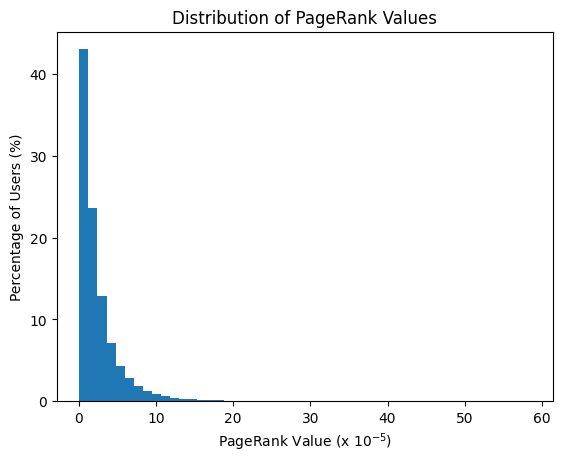

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Collect the PageRank values and rescale them
pagerank_values = [value * 10**5 for value in result1.vertices.select('pagerank').rdd.flatMap(lambda x: x).collect()]

# Calculate the weights for each bin to normalize the histogram
weights = np.ones_like(pagerank_values) / len(pagerank_values)

# Plot a histogram with y-axis as percentage
plt.hist(pagerank_values, bins= 50, weights=weights*100)

plt.xlabel('PageRank Value (x $10^{-5}$)')
plt.ylabel('Percentage of Users (%)')
plt.title('Distribution of PageRank Values')
plt.show()


In [ ]:
result2 = page_rank(graph, sourceId="148398", maxIter=5)

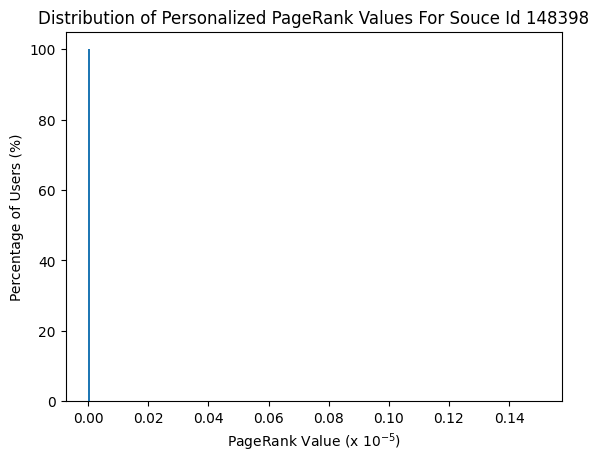

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Collect the PageRank values and rescale them
pagerank_values = [value for value in result2.vertices.select('pagerank').rdd.flatMap(lambda x: x).collect()]

# Calculate the weights for each bin to normalize the histogram
weights = np.ones_like(pagerank_values) / len(pagerank_values)

# Plot a histogram with y-axis as percentage
plt.hist(pagerank_values, bins=50, weights=weights*100)

plt.xlabel('PageRank Value (x $10^{-5}$)')
plt.ylabel('Percentage of Users (%)')
plt.title('Distribution of Personalized PageRank Values For Souce Id 148398')
plt.show()

In [11]:
#Bfs functions
def bfs(graph, root, max_iter=5):
    g_bfs = graph.pregel \
        .setMaxIter(max_iter) \
        .withVertexColumn("dist",
                          f.when(graph.vertices.id==root,f.lit(0.0))\
                          .otherwise(f.lit(float('inf'))),
                          f.coalesce(Pregel.msg(),\
                                     f.lit(float('inf')))) \
        .sendMsgToDst(f.when(Pregel.src("dist") + 1. < Pregel.dst("dist"),
                             Pregel.src("dist") + 1.)\
                      .otherwise(Pregel.dst("dist")))\
        .aggMsgs(f.min(Pregel.msg()))\
        .run()
    return g_bfs

def bfs_two(graph, source_id, target_id, max_iter=5):
    """
    Calculate the degree of separation between two users using BFS.

    :param graph: GraphFrame representing the graph.
    :param source_id: The id of the source user.
    :param target_id: The id of the target user.
    :param max_iter: The maximum number of iterations for BFS.
    :return: The degree of separation between source_id and target_id.
    """

    # BFS from source_id
    result = bfs(graph,source_id,max_iter)

    # Find the distance to target_id
    degree_of_separation = result.filter(result.id == target_id).select("dist").first()

    if degree_of_separation is None:
        # target_id is not reachable from source_id
        return float('inf')
    else:
        return degree_of_separation["dist"]

def bfs_two2(result, target_id, max_iter=5):
    """
    Calculate the degree of separation between two users using BFS.

    :param graph: GraphFrame representing the graph.
    :param source_id: The id of the source user.
    :param target_id: The id of the target user.
    :param max_iter: The maximum number of iterations for BFS.
    :return: The degree of separation between source_id and target_id.
    """

    # BFS from source_id
    result = result

    # Find the distance to target_id
    degree_of_separation = result.filter(result.id == target_id).select("dist").first()

    if degree_of_separation is None:
        # target_id is not reachable from source_id
        return float('inf')
    else:
        return degree_of_separation["dist"]


In [12]:
# Calculate the degree of separation between the two users (graph2 is without self loops)

twitch_gamers_full = spark.read.format("csv").option("header", "true").load(
    "/content/drive/MyDrive/twitch_gamers/large_twitch_edges.csv").withColumnRenamed("numeric_id_1",
                                                                                          "src").withColumnRenamed(
    "numeric_id_2", "dst")

vertices2 = twitch_gamers_full.select("src").union(twitch_gamers_full.select("dst")).distinct().withColumnRenamed("src", "id")
vertices2.cache()

edges2 = twitch_gamers_full.select("src", "dst")
edges2.cache()

graph2 = GraphFrame(vertices2, edges2)

In [15]:
degree = bfs_two(graph2, 1, 2)
print(f"The degree of separation between user 1 and user 2 is {degree}.")

The degree of separation between user 1 and user 2 is 3.0.


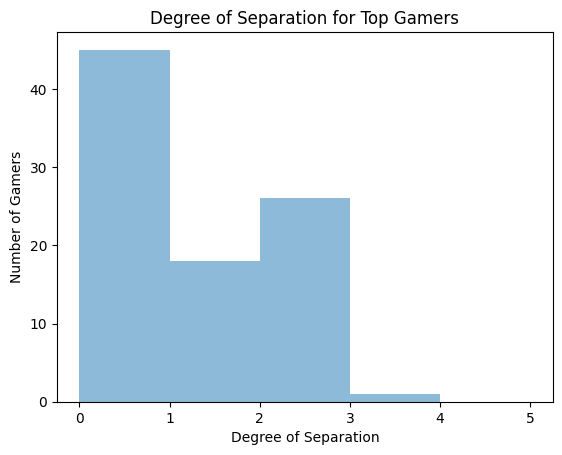

In [18]:
# Compare high page ranks user to each other and their degree of seperation and low page rank users histogram with combinations
import matplotlib.pyplot as plt

# Comparing degrees of separation of top gamers

# Get the IDs of the top gamers
top_ids = top_10_users.select("id").rdd.flatMap(lambda x: x).collect()

# Convert the IDs to integers
top_ids = [int(id) for id in top_ids]

# Initialize an empty list to store all degrees of separation
top_degrees = []

# Loop over all top gamers
for i in range(10):
    # Perform BFS from the current gamer
    result_bfs = bfs(graph2, top_ids[i])

    # Calculate the degree of separation between the current gamer and all other top gamers
    degrees = [bfs_two2(result_bfs, id) for id in top_ids if id != top_ids[i]]

    # Add the degrees of separation to the list
    top_degrees.extend(degrees)

# Replace infinite degrees of separation with 0
top_degrees = [0 if degree == float('inf') else degree for degree in top_degrees]

# Plot the degrees of separation for the top gamers
plt.hist(top_degrees, bins=range(0, 6), alpha=0.5, label='Top Gamers')

plt.xlabel('Degree of Separation')
plt.ylabel('Number of Gamers')
plt.title('Degree of Separation for Top Gamers')
plt.show()

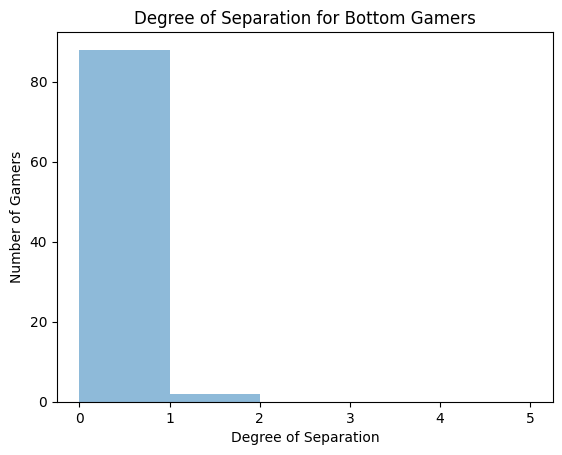

In [19]:
import matplotlib.pyplot as plt

# Comparing degrees of seperation of bottom gamers

# Get the IDs of the bottom gamers
bottom_ids = bottom_10_users.select("id").rdd.flatMap(lambda x: x).collect()

# Convert the IDs to integers
bottom_ids = [int(id) for id in bottom_ids]

# Initialize an empty list to store all degrees of separation
bottom_degrees = []

# Loop over all bottom gamers
for i in range(10):
    # Perform BFS from the current gamer
    result_bfs = bfs(graph2, bottom_ids[i])

    # Calculate the degree of separation between the current gamer and all other top gamers
    degrees = [bfs_two2(result_bfs, id) for id in bottom_ids if id != bottom_ids[i]]

    # Add the degrees of separation to the list
    bottom_degrees.extend(degrees)

# Replace infinite degrees of separation with 0
bottom_degrees = [0 if degree == float('inf') else degree for degree in bottom_degrees]

# Plot the degrees of separation for the bottom gamers
plt.hist(bottom_degrees, bins=range(0, 6), alpha=0.5, label='Bottom Gamers')

plt.xlabel('Degree of Separation')
plt.ylabel('Number of Gamers')
plt.title('Degree of Separation for Bottom Gamers')
plt.show()